In [1]:
import pandas as pd
import datetime
import csv
import numpy as np
import matplotlib.pyplot as plt

To convert the ['Date of Travrel'] values into date format, i used this function authored by @alaudet https://gist.github.com/alaudet/307ac574973028497d083f6d43575214

In [2]:
def date_to_string(digit_date):
    new_form = []
    for d in digit_date:
        try:
            x = datetime.date(1899,12,30) + datetime.timedelta(days=float(d))
            new_form.append(x.strftime('%Y-%m-%d'))
        except:
            new_form.append('n/a')
    return new_form

# Import CSV data

In [3]:
cab_data = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv')
# the date are converted here, and there's no null value.
cab_data['Date of Travel'] = date_to_string(cab_data['Date of Travel'])
# cab_data['Date of Travel'] = pd.to_datetime(cab_data['Date of Travel'], errors='coerce')
cab_data.head()


,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
list = []
# cab_data_company = pd.read_csv('~/dg_intern/DataSets/Cab_Data.csv', usecols=['Company'])
for name in cab_data['Company']:
    if list != []:
        if name in list:
            continue
        else:
            list.append(name)
    elif list == []:
        list.append(name)
# print(list)
print('The companies we are assessing are ' + str(list))

The companies we are assessing are ['Pink Cab', 'Yellow Cab']


In [5]:
city = pd.read_csv('~/dg_intern/DataSets/City.csv')
print('We have data collected from ' + str(len(city['City'])) + ' cities in total.')
city.head()

We have data collected from 20 cities in total.


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [6]:
customer_id = pd.read_csv('~/dg_intern/DataSets/Customer_ID.csv')
customer_id.head()


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [8]:

transaction = pd.read_csv('~/dg_intern/DataSets/Transaction_ID.csv')
transaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


# Establish the relational database

In [9]:
output1 = pd.merge(cab_data, transaction, 
                   on='Transaction ID', 
                   how='inner')
cab_trans_customer = pd.merge(output1, customer_id, 
                   on='Customer ID', 
                   how='inner')
cab_trans_customer.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237


# General information

## annual profit

In [10]:
profit_pi = [[],[],[]]
profit_ye = [[],[],[]]

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    if name == 'Pink Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_pi[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_pi[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_pi[2].append(a)
    elif name == 'Yellow Cab':
        if cab_trans_customer['Date of Travel'][i][:4] == '2016':
            profit_ye[0].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2017':
            profit_ye[1].append(a)
        elif cab_trans_customer['Date of Travel'][i][:4] == '2018':
            profit_ye[2].append(a)
    else:
        print('missing')
        

In [11]:
ann_profit = np.ma.zeros((2, 3)) # (company, year)
for j in range(3):
        ann_profit[0,j] = sum(profit_pi[j])
        ann_profit[1,j] = sum(profit_ye[j])
    


In [12]:
print(ann_profit)

[[ 1713511.224       2033654.90800001  1560162.18899998]
 [13926995.43159986 16575977.96800002 13517399.77119991]]


## seasonal profits

In [14]:
profit_pi_sea = [[0]*12 for i in range(3)]
profit_ye_sea = [[0]*12 for i in range(3)]
profit_pi_sea_list = np.ma.zeros((3,12,31))
profit_ye_sea_list = np.ma.zeros((3,12,31))
total_ride_profit = np.ma.zeros((2,3,12,31))
total_day = np.ma.zeros((2,3,12,31))

# To divide data based on company
for i, name in enumerate(cab_trans_customer['Company']):
    a = cab_trans_customer['Price Charged'][i] - cab_trans_customer['Cost of Trip'][i]
    mon = 10* int(cab_trans_customer['Date of Travel'][i][5]) + int(cab_trans_customer['Date of Travel'][i][6])
    day = 10* int(cab_trans_customer['Date of Travel'][i][8]) + int(cab_trans_customer['Date of Travel'][i][9])
    if name == 'Pink Cab':
        profit_pi_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
        profit_pi_sea_list[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += a
        total_day[0,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
        if a > 0:
            total_ride_profit[0,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
            
        
    elif name == 'Yellow Cab':
        profit_ye_sea[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016][mon-1] += a
        profit_ye_sea_list[int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += a
        total_day[1,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
        if a > 0:
            total_ride_profit[1,int(cab_trans_customer['Date of Travel'][i][:4]) - 2016, mon - 1, day - 1] += 1
    else:
        print('missing')
        


In [15]:
sea_profit = np.ma.empty((2,3,4)) # two companies, 3 years, 4 seasons
for j in range(3):
    sea_profit[0,j,0] = np.sum(profit_pi_sea_list[j,:3,:])
    sea_profit[0,j,1] = np.sum(profit_pi_sea_list[j,3:6,:])
    sea_profit[0,j,2] = np.sum(profit_pi_sea_list[j,6:9,:])
    sea_profit[0,j,3] = np.sum(profit_pi_sea_list[j,9:12,:])
    
    sea_profit[1,j,0] = np.sum(profit_ye_sea_list[j,:3,:])
    sea_profit[1,j,1] = np.sum(profit_ye_sea_list[j,3:6,:])
    sea_profit[1,j,2] = np.sum(profit_ye_sea_list[j,6:9,:])
    sea_profit[1,j,3] = np.sum(profit_ye_sea_list[j,9:12,:])



# profitable days (rides)

In [16]:
def count_profitable_day(profit):
    profit = np.reshape(profit, -1)
    count = 0
    for i in range(len(profit)):
        if profit[i] > 0:
            count+=1
        else:
            continue 
    return count

In [17]:
def total_day(day):
    day = np.reshape(day, -1)
    day[day == 0] = np.nan
    return len(day[~np.isnan(day)])

In [18]:
profit_day = np.ma.empty((2, 3, 5)) # (company, )
# 2016
for j in range(3):
        profit_day[0,j,0] = count_profitable_day(profit_pi_sea_list[j,:,:]) / total_day(profit_pi_sea_list[j,:,:])
        profit_day[0,j,1] = count_profitable_day(profit_pi_sea_list[j,:3,:]) / total_day(profit_pi_sea_list[j,:3,:])
        profit_day[0,j,2] = count_profitable_day(profit_pi_sea_list[j,3:6,:]) / total_day(profit_pi_sea_list[j,3:6,:])
        profit_day[0,j,3] = count_profitable_day(profit_pi_sea_list[j,6:9,:]) / total_day(profit_pi_sea_list[j,6:9,:])
        profit_day[0,j,4] = count_profitable_day(profit_pi_sea_list[j,9:12,:]) / total_day(profit_pi_sea_list[j,9:12,:])
    
        profit_day[1,j,0] = count_profitable_day(profit_ye_sea_list[j,:,:]) / total_day(profit_ye_sea_list[j,:,:])
        profit_day[1,j,1] = count_profitable_day(profit_ye_sea_list[j,:3,:]) / total_day(profit_ye_sea_list[j,:3,:])
        profit_day[1,j,2] = count_profitable_day(profit_ye_sea_list[j,3:6,:]) / total_day(profit_ye_sea_list[j,3:6,:])
        profit_day[1,j,3] = count_profitable_day(profit_ye_sea_list[j,6:9,:]) / total_day(profit_ye_sea_list[j,6:9,:])
        profit_day[1,j,4] = count_profitable_day(profit_ye_sea_list[j,9:12,:]) / total_day(profit_ye_sea_list[j,9:12,:])


In [19]:
print(profit_day)

[[[0.99726027 1.         0.98901099 1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]

 [[1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]
  [1.         1.         1.         1.         1.        ]]]


## total seasonal profits/ total annual profits

In [55]:
sea_ann_profit = np.ma.empty((2, 4))
for i in range(2):
    for sea in range(4):
        sum_ann_profit = sum(ann_profit[i, :]) #(company, year)
        sum_sea_profit = sum(sea_profit[i, :, sea]) #(company, year, season)
        sea_ann_profit[i, sea] = sum_sea_profit / sum_ann_profit
        sea_ann_profit[i, sea] = "{:.3f}".format(sea_ann_profit[i, sea])

In [56]:
print(sea_ann_profit)

[[0.177 0.122 0.223 0.478]
 [0.215 0.242 0.224 0.319]]


尚未画图

## portion of seasonal profits of each year: seasonal profit each year / total profit each year

尚未画图，portion of each year

In [22]:
sea_profit_annpor = np.ma.empty((2, 3, 4))
for i in range(2):
    for iyear in range(3):
        for k in range(4):
            sea_profit_annpor[i, iyear, k] = sea_profit[i, iyear, k] / ann_profit[i,iyear]

In [23]:
print(sea_profit_annpor)

[[[0.14544964 0.12561696 0.22256961 0.5063638 ]
  [0.1764916  0.12623447 0.22924015 0.46803378]
  [0.212183   0.11228565 0.21600372 0.45952763]]

 [[0.19819365 0.24986019 0.22960786 0.32233829]
  [0.21734412 0.23674043 0.22688004 0.31903542]
  [0.23101306 0.23935217 0.21466472 0.31497004]]]


## plots

In [52]:
print("{:.2f}".format(p) for p in sea_ann_profit[0])
mm = 100*sea_ann_profit[0]
print("%.2f" % m for m in mm)
x = 211911461911461819112146
y = 2**70
z = x / y

print("%.2f" % z)

<generator object <genexpr> at 0x7fb5cac4a350>
<generator object <genexpr> at 0x7fb5cac4a350>
179.50


Annual Profits of from 2016 to 2018
[[0.177 0.122 0.223 0.478]
 [0.215 0.242 0.224 0.319]]


/var/folders/md/twjjy3517bx9b44nk_x7wtbm0000gn/T/ipykernel_12873/3421956278.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([0, 10, 20, 30, 40, 50])


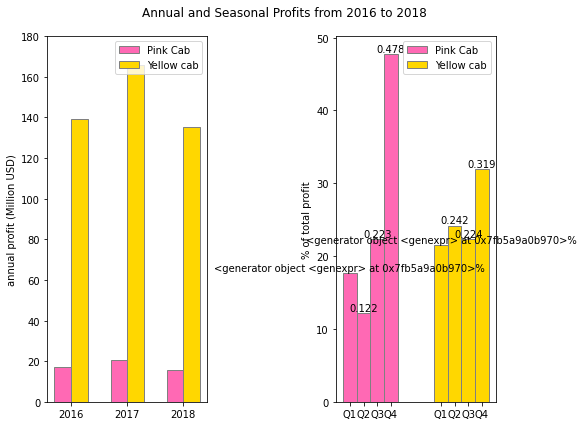

In [61]:
print('Annual Profits of from 2016 to 2018')
print(sea_ann_profit)
barWidth = 0.3
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Annual and Seasonal Profits from 2016 to 2018')
axs[0].bar(br1, ann_profit[0], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[0].bar(br2, ann_profit[1], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_xticks([r + 0.5*barWidth for r in range(3)], ['2016','2017','2018'])
axs[0].set_yticks(np.arange(0.0e7,2.0e7,0.2e7))
axs[0].set_yticklabels(['0', '20', '40', '60', '80', '100', '120', '140', '160','180'])
axs[0].set_ylabel('annual profit (Million USD)')

# sea_ann_profit
b1 = np.arange(4)
br1 = [x*barWidth for x in b1]
br2 = [2 + x*barWidth for x in b1]

pi_sea = axs[1].bar(br1, sea_ann_profit[0], width = barWidth, color = 'hotpink', align='center', label = 'Pink Cab', edgecolor ='grey')
ye_sea = axs[1].bar(br2, sea_ann_profit[1], width = barWidth, color = 'gold', align='center', label = 'Yellow Cab', edgecolor ='grey')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_xticks([0.0, 0.3, 0.6, 0.8999999999999999,2.0, 2.3, 2.6, 2.9], ['Q1','Q2','Q3','Q4', 'Q1','Q2','Q3','Q4'])
axs[1].set_yticklabels([0, 10, 20, 30, 40, 50])
axs[1].set_ylabel('% of total profit')

# # Label with label_type the default 'edge'
axs[1].bar_label(pi_sea,labels=[str(p for p in 100*sea_ann_profit[0])+'%'])
axs[1].bar_label(ye_sea,labels=[str(p for p in 100*sea_ann_profit[1])+'%'])

fig.tight_layout()



label the percentage, group by company

Seasonal Profits of from 2016 to 2018
[[[ 249229.59    215246.063   381375.523   867660.048 ]
  [ 358923.005   256717.349   466195.359   951819.195 ]
  [ 331039.887   175183.83    337000.84    716937.632 ]]

 [[2760242.0676 3479801.79   3197747.6144 4489203.9596]
  [3602691.3216 3924204.07   3760758.5584 5288324.018 ]
  [3122695.9248 3235419.0188 2901708.8556 4257575.972 ]]]


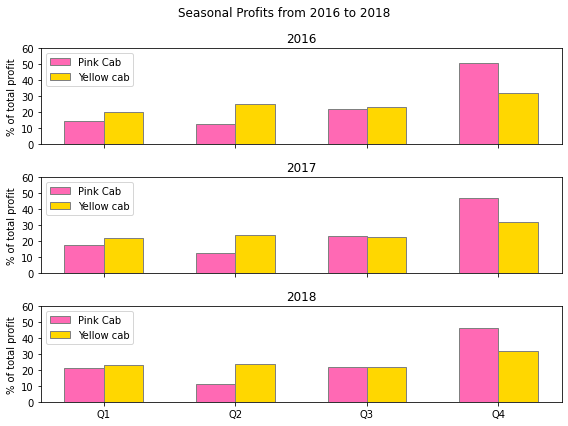

In [26]:
print('Seasonal Profits of from 2016 to 2018')
print(sea_profit)

barWidth = 0.3
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]

fig, axs = plt.subplots(3,1, sharex=True, figsize= (8,6))

# fig, axs = plt.subplots(nrows=1,ncols=2, figsize= (8,6))
fig.suptitle('Seasonal Profits from 2016 to 2018')

axs[0].bar(br1, sea_profit_annpor[0,0,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[0].bar(br2, sea_profit_annpor[1,0,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[0].legend(['Pink Cab', 'Yellow cab'])
axs[0].set_title('2016')
axs[0].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[0].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[0].set_ylabel('% of total profit')

axs[1].bar(br1, sea_profit_annpor[0,1,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[1].bar(br2, sea_profit_annpor[1,1,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[1].legend(['Pink Cab', 'Yellow cab'])
axs[1].set_title('2017')
axs[1].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[1].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[1].set_ylabel('% of total profit')

axs[2].bar(br1, sea_profit_annpor[0,2,:], width = barWidth, color = 'hotpink', align='center', edgecolor ='grey')
axs[2].bar(br2, sea_profit_annpor[1,2,:], width = barWidth, color = 'gold', align='center', edgecolor ='grey')
axs[2].legend(['Pink Cab', 'Yellow cab'])
axs[2].set_title('2018')
axs[2].set_xticks([r + 0.5*barWidth for r in range(4)], ['Q1','Q2','Q3','Q4'])
axs[2].set_yticks(np.arange(0,0.7,0.1),[0, 10, 20, 30, 40, 50, 60])
axs[2].set_ylabel('% of total profit')

fig.tight_layout()


# city-wise profits

# customers

## annual

## seasonal

## city-wise customers